CONFIRM CASES


In [ ]:
pip install helper

**importing important libraries**

In [3]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


**Reading the dataset**

In [4]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [5]:
q=dataframe.query('Country=="Brazil"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     241080
2020-05-18     255368
2020-05-19     271885
2020-05-20     291579
2020-05-21     310087

[121 rows x 1 columns]

**Spiliting the dataset**

In [6]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28      73235
2020-04-29      79685
2020-04-30      87187
2020-05-01      92202
2020-05-02      97100
2020-05-03     101826
2020-05-04     108620
2020-05-05     115455
2020-05-06     126611
2020-05-07     135773
2020-05-08     146894
2020-05-09     156061
2020-05-10     162699
2020-05-11     169594
2020-05-12     178214
2020-05-13     190137
2020-05-14     203165
2020-05-15     220291
2020-05-16     233511
2020-05-17     241080
2020-05-18     255368
2020-05-19     271885
2020-05-20     291579
2020-05-21     310087

In [7]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


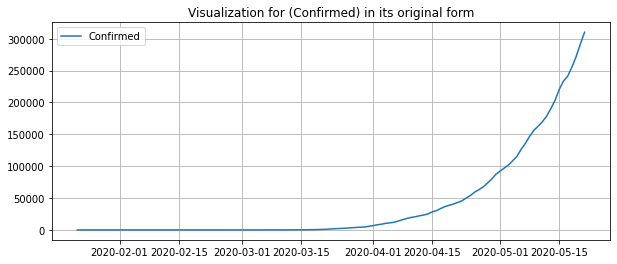

In [8]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [9]:
df.tail()

Confirmed
Date                 
2020-05-17     241080
2020-05-18     255368
2020-05-19     271885
2020-05-20     291579
2020-05-21     310087

In [10]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [11]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     241080
2020-05-18     255368
2020-05-19     271885
2020-05-20     291579
2020-05-21     310087

In [12]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [13]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [14]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [19]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [20]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [21]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 82912.18701615374, 40444.545454545456)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 82912.18701615374, 40444.545454545456)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 72285.2046459182, 52187.425995492114)
([(0, 0, 0), (0, 0, 0, 365), 't'], 54653.35062517698, 42094.30441857338)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 47427.046944375405, 37281.10795069427)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 42430.584511609035, 20740.2798143079)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 38539.61989690999, 27404.281733578366)
([(0, 0, 1), (0, 0, 0, 365), 't'], 28018.715514694737, 21778.97556601358)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 47794.6663454607, 36633.49649397071)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 22712.453080618718, 11063.713194056603)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 70786.16335735013, 36747.01204851367)
([(0, 0, 2), (0, 0, 0, 365), 't'], 15290.14619213382, 12404.930901715841)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 321186.42511563806, 244102.55882895368)
([(0, 1, 0), (0, 0, 0, 365), 

In [22]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(1, 0, 2), (0, 0, 0, 365), 'ct'] 1042.5490435601714 505.18779594714243


In [23]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

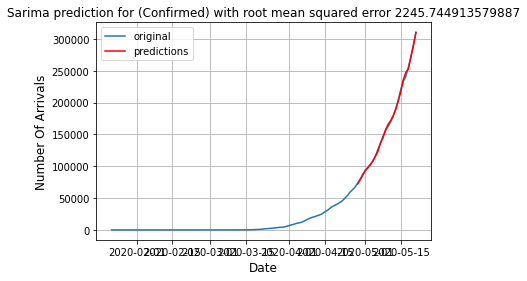

In [24]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [25]:
errors = mape(test, predictions)
errors

54.84039253405422

In [ ]:
#Recovered Cases in Brazil'''

RECOVERED CASES

In [26]:
q=dataframe.query('Country=="Brazil"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17      94122
2020-05-18     100459
2020-05-19     106794
2020-05-20     116683
2020-05-21     125960

[121 rows x 1 columns]

**Spliting the dataset**

In [27]:
trainr=dfr[0:97]
testr=dfr[97:]
len(testr)

24

In [28]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


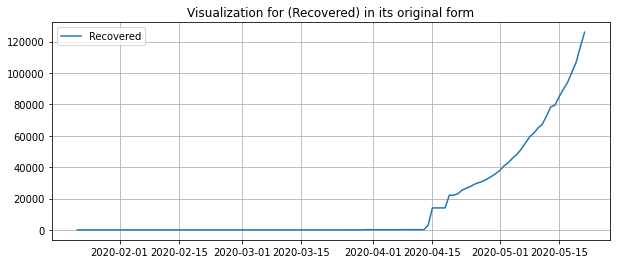

In [29]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [30]:
dfr.tail()

Recovered
Date                 
2020-05-17      94122
2020-05-18     100459
2020-05-19     106794
2020-05-20     116683
2020-05-21     125960

In [31]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [32]:
df_to_test.tail()

Recovered
Date                 
2020-05-17      94122
2020-05-18     100459
2020-05-19     106794
2020-05-20     116683
2020-05-21     125960

In [ ]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [34]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [35]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [36]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [37]:

print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 33361.9615624969, 15920.570247933885)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 33361.9615624969, 15920.570247933885)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 29282.4379769343, 22012.047879243222)
([(0, 0, 0), (0, 0, 0, 365), 't'], 22348.014017297937, 17084.115190561068)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 19403.020369949703, 15115.614476378654)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 17678.698635057874, 8330.320991396935)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 15819.708400749349, 11838.558091720357)
([(0, 0, 1), (0, 0, 0, 365), 't'], 12009.738650949866, 9371.382172144165)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 10867.502429434737, 8222.892645871321)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 38755.305807492085, 18316.013351860463)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 12542.266276908042, 8711.429348831978)
([(0, 0, 2), (0, 0, 0, 365), 't'], 25829.352170231155, 21370.696818014687)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 58246.628188428054, 41090.20419670862)
([(0, 1, 0), (0, 0, 0, 

In [38]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 2), (0, 0, 0, 365), 'ct'] 1346.3680387282204 557.2027144992571


In [39]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

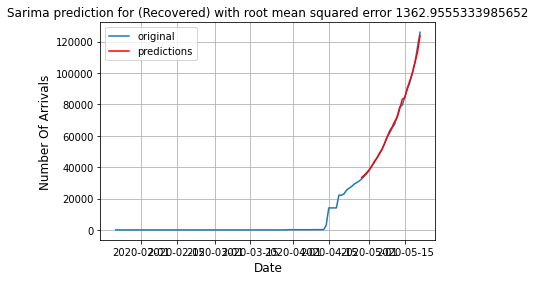

In [40]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [41]:
mape(testr, predictions)

50.26212382478696

In [ ]:
# Deaths cases

DEATH CASES

In [42]:
q=dataframe.query('Country=="Brazil"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   16118
2020-05-18   16853
2020-05-19   17983
2020-05-20   18859
2020-05-21   20047

[121 rows x 1 columns]

In [43]:
# Seriies to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


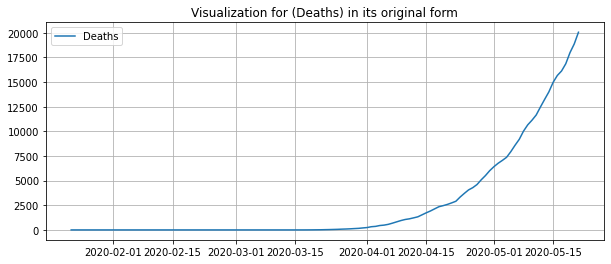

In [44]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [45]:
dfd.tail()

Deaths
Date              
2020-05-17   16118
2020-05-18   16853
2020-05-19   17983
2020-05-20   18859
2020-05-21   20047

**Splitting the dataset**

In [46]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28    5083
2020-04-29    5513
2020-04-30    6006
2020-05-01    6412
2020-05-02    6761
2020-05-03    7051
2020-05-04    7367
2020-05-05    7938
2020-05-06    8588
2020-05-07    9190
2020-05-08   10017
2020-05-09   10656
2020-05-10   11123
2020-05-11   11653
2020-05-12   12461
2020-05-13   13240
2020-05-14   13999
2020-05-15   14962
2020-05-16   15662
2020-05-17   16118
2020-05-18   16853
2020-05-19   17983
2020-05-20   18859
2020-05-21   20047

In [47]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [48]:
df_to_test.tail()

Deaths
Date              
2020-05-17   16118
2020-05-18   16853
2020-05-19   17983
2020-05-20   18859
2020-05-21   20047

In [49]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [50]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [51]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [52]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [53]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 5556.45072739338, 2681.710743801653)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 5556.45072739338, 2681.710743801653)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 4860.363946140988, 3548.6960590123626)
([(0, 0, 0), (0, 0, 0, 365), 't'], 3690.7738219142684, 2871.930503037828)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 3202.3590064851965, 2540.2033462717473)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 5629.216115546602, 2716.5901484368446)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 2570.5263090294125, 1875.2379797632157)
([(0, 0, 1), (0, 0, 0, 365), 't'], 3753.5246122753438, 2931.3623282924027)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 3374.753779629064, 2535.0178792986244)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 1505.3202094241408, 725.5614550659922)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 1375.903072149225, 1013.4132403905071)
([(0, 0, 2), (0, 0, 0, 365), 't'], 1379.7848409815379, 1218.120049098822)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 971.3144061975325, 749.6486224806107)
([(0, 1, 0), (0, 0, 0, 365), '

In [54]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 1, 2), (0, 0, 0, 365), 'ct'] 70.87820433622134 39.00444081156023


In [55]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

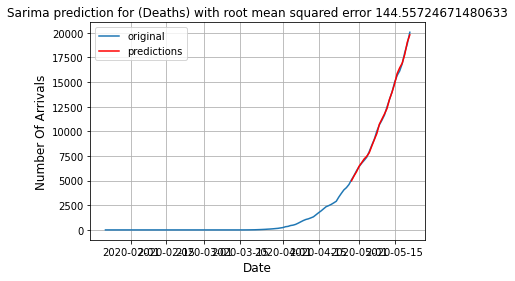

In [56]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [57]:
mape(testd,predictions)

52.33855468502614